<a href="https://colab.research.google.com/github/aojedao/AdvancedMechatronics/blob/main/MiniProject2/Code/IMU%2BEncoders1/Sensor_fusion_using_kalman_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install filterpy numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=8533932962f8a628d98e366db1032ec191c4fd885739d4c80574e7a6c648d12e
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise


In [3]:
WHEEL_RADIUS = 0.0325  # meters
WHEEL_DISTANCE = 0.20  # meters
TICKS_PER_REVOLUTION = 937  # encoder ticks per wheel revolution
ENCODER_RESOLUTION = 2 * np.pi / TICKS_PER_REVOLUTION  # radians per tick


In [4]:
dt = 0.1  # time step in seconds
total_time = 10  # total simulation time in seconds
time_steps = int(total_time / dt)

# Simulated true velocities
linear_velocity = 0.1  # m/s
angular_velocity = 0.05  # rad/s

# Initialize arrays to store simulated data
imu_data = []
encoder_data = []

for _ in range(time_steps):
    # Simulate IMU gyroscope data (angular velocity around z-axis)
    imu_gyro_z = angular_velocity + np.random.normal(0, 0.01)  # adding noise
    imu_data.append(imu_gyro_z)

    # Simulate encoder data
    v_r = linear_velocity + (angular_velocity * WHEEL_DISTANCE / 2)
    v_l = linear_velocity - (angular_velocity * WHEEL_DISTANCE / 2)

    omega_r = v_r / WHEEL_RADIUS  # angular velocity of right wheel
    omega_l = v_l / WHEEL_RADIUS  # angular velocity of left wheel

    ticks_r = omega_r * dt / ENCODER_RESOLUTION
    ticks_l = omega_l * dt / ENCODER_RESOLUTION

    encoder_data.append((ticks_r, ticks_l))


In [8]:
def fx(x, dt):
    """ State transition function for the EKF. """
    theta = x[2]
    v = x[3]
    w = x[4]
    if np.abs(w) < 1e-5:
        # Straight motion
        dx = v * np.cos(theta) * dt
        dy = v * np.sin(theta) * dt
        dtheta = w * dt
    else:
        # Rotational motion
        dx = (v/w) * (np.sin(theta + w*dt) - np.sin(theta))
        dy = (v/w) * (-np.cos(theta + w*dt) + np.cos(theta))
        dtheta = w * dt
    return x + np.array([dx, dy, dtheta, 0, 0])

def hx(x):
    """ Measurement function. """
    return np.array([x[2], x[3], x[4]])  # returning theta, v, w
# Define process noise variances for each state variable
var_x = 0.01        # Variance for x position
var_y = 0.01        # Variance for y position
var_theta = 0.001   # Variance for orientation (theta)
var_v = 0.1         # Variance for linear velocity
var_w = 0.01        # Variance for angular velocity

# Construct the diagonal covariance matrix

ekf = ExtendedKalmanFilter(dim_x=5, dim_z=3)
ekf.Q = np.diag([var_x, var_y, var_theta, var_v, var_w])
ekf.x = np.array([0, 0, 0, 0, 0])  # initial state: x, y, theta, v, w
ekf.F = np.eye(5)  # state transition matrix
ekf.R = np.diag([0.1, 0.1, 0.1])  # measurement noise
#ekf.Q = Q_discrete_white_noise(dim=5, dt=dt, var=0.1)  # process noise
ekf.P *= 10  # covariance matrix


In [9]:
estimated_states = []

for i in range(time_steps):
    # Predict step
    ekf.predict()

    # Measurement update
    imu_measurement = imu_data[i]
    encoder_measurement = encoder_data[i]

    # Convert encoder ticks to linear and angular velocities
    d_right = encoder_measurement[0] * ENCODER_RESOLUTION * WHEEL_RADIUS
    d_left = encoder_measurement[1] * ENCODER_RESOLUTION * WHEEL_RADIUS

    v = (d_right + d_left) / 2.0 / dt
    w = (d_right - d_left) / WHEEL_DISTANCE / dt

    z = np.array([imu_measurement, v, w])

    ekf.update(z, HJacobian=lambda x: np.eye(3, 5), Hx=hx)

    estimated_states.append(ekf.x[:3])  # Store x, y, theta


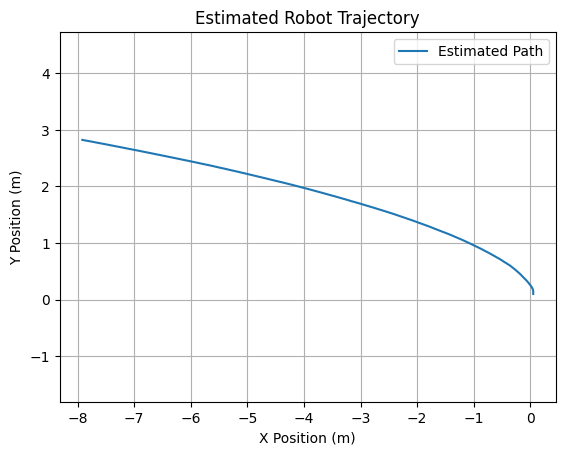

In [10]:
estimated_states = np.array(estimated_states)
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='Estimated Path')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Estimated Robot Trajectory')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()
